In [12]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from etf_tools import (
    EstimatorBucket,
    prepare_etf, ez_plot,
    evaluate_stacking
)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import shuffle as sk_shuffle
import xgboost as xgb

plt.style.use('ggplot')
plt.ioff()


In [13]:
class XgbBucket(EstimatorBucket):
    def __init__(self, params, num_boost_round=10, **kwargs):
        self.params = params
        self.num_boost_round = num_boost_round
        self.kwargs = kwargs

    def draw(self, x, y):
        x, y = sk_shuffle(x, y)
        dtrain = xgb.DMatrix(x, label=y)
        bst = xgb.train(self.params, dtrain, num_boost_round=self.num_boost_round, **self.kwargs)
        return bst

def uniform_weighting(est, *args, **kwargs):
    return [1] * len(est)


def patched_accuracy_score(threshold=0.5):
    def acc(y_actual, y_pred):
        yp = 1 * (y_pred >= threshold)
        return accuracy_score(y_actual, yp)
    return acc


In [5]:
src_dir = '../data/raw/groupbycode/trainingset/'
code = '0050'
sample_file = os.path.join(src_dir, f'{code}.csv')


In [6]:
cont_feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'ema12', 'ema26', 'rsv', 'k', 'd', 'upward',
    'downward', 'rsi', 'open_gap', 'macd', 'osc', 'kbody'
]
cate_feature_cols = [f'month_{i + 1}' for i in range(12)] + [f'week_{i + 1}' for i in range(5)]

label_cols = ['y_1']


def feature_prep(df):
    months = pd.get_dummies(pd.Series(df.date.apply(lambda e: (e // 100) % 100)), prefix='month')
    weeks = pd.get_dummies(pd.Series(df.date.apply(lambda e: 1 + (e % 100) // 7)), prefix='week')
    return pd.concat([months, weeks, df[cont_feature_cols]], axis=1)


def rnn_feature_trans(df):
    conts = df[cont_feature_cols]
    norms = ((conts - conts.mean()) / conts.std()).fillna(0)
    return pd.concat([df[cate_feature_cols], norms], axis=1)


def xgb_feature_trans(df):
    return pd.Series(rnn_feature_trans(df).values.flatten())

In [7]:
%%time

X_all, y_all = prepare_etf(sample_file, cont_feature_cols + cate_feature_cols, label_cols, window=5,
                           etf_prep=lambda df: df.dropna(subset=label_cols),
                           feature_prep=feature_prep,
                           label_prep=lambda df: 1 * (df[label_cols].diff().fillna(0) > 0),
                           feature_trans=xgb_feature_trans)


CPU times: user 3.2 s, sys: 20 ms, total: 3.22 s
Wall time: 3.31 s


In [8]:
dtrain = xgb.DMatrix(
    X_all,
    label=y_all,
)

In [9]:
params={ 
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'seed':0, 

    'max_depth': 5,
    'min_child_weight': 9,
    
    'n_estimators': 10,
    'eta': 0.01,  # eta
    'subsample': 0.5,
    'colsample_bytree': 0.5, 
    'nthread': 16,
}

xgb_bucket = XgbBucket(params, num_boost_round=1000, early_stopping_rounds=None)

In [10]:
(X_train, y_train), (X_val, y_val) = (X_all[:-10], y_all[:-10]), (X_all[-10:], y_all[-10:])

In [14]:
%%time
tic = time.time()
n_stack = 50
z = [evaluate_stacking(xgb_bucket, uniform_weighting, x_val=xgb.DMatrix(X_val), y_val=np.vstack(y_val),
                       bucket_kwargs=dict(x=X_train, y=y_train),
                       metrics=[roc_auc_score], n_stack=50) for _ in range(10)]

toc = time.time()

CPU times: user 3h 14min 29s, sys: 4min 3s, total: 3h 18min 33s
Wall time: 13min 23s


In [15]:
print(f'{toc - tic:.3f}')

803.823


In [16]:
zz = pd.concat(z, axis=0)
zz.columns = [f'{i + 1}' for i in range(n_stack)]
display(zz)

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
roc_auc_score,0.714286,0.738095,0.746032,0.761905,0.800000,0.793651,0.809524,0.803571,0.798942,0.790476,...,0.765389,0.764172,0.765227,0.765152,0.766138,0.762940,0.762918,0.760913,0.759961,0.760000
roc_auc_score,0.714286,0.785714,0.777778,0.809524,0.819048,0.801587,0.802721,0.803571,0.798942,0.809524,...,0.768873,0.768707,0.767442,0.765152,0.765079,0.766046,0.766971,0.766865,0.766764,0.769524
roc_auc_score,0.666667,0.714286,0.714286,0.714286,0.704762,0.714286,0.721088,0.732143,0.740741,0.747619,...,0.754936,0.755102,0.755260,0.753247,0.753439,0.754658,0.754813,0.752976,0.752187,0.751429
roc_auc_score,0.761905,0.738095,0.746032,0.750000,0.742857,0.746032,0.748299,0.750000,0.751323,0.747619,...,0.763066,0.763039,0.763012,0.762987,0.764021,0.763975,0.763931,0.763889,0.763848,0.763810
roc_auc_score,0.714286,0.738095,0.746032,0.761905,0.752381,0.738095,0.741497,0.738095,0.735450,0.738095,...,0.754936,0.756236,0.761905,0.760823,0.761905,0.765010,0.762918,0.758929,0.758989,0.759048
roc_auc_score,0.809524,0.785714,0.793651,0.773810,0.780952,0.769841,0.761905,0.761905,0.761905,0.776190,...,0.766551,0.765306,0.766334,0.766234,0.765079,0.763975,0.761905,0.762897,0.762877,0.762857
roc_auc_score,0.761905,0.761905,0.746032,0.761905,0.723810,0.738095,0.741497,0.744048,0.751323,0.757143,...,0.765389,0.765306,0.765227,0.765152,0.762963,0.762940,0.759878,0.757937,0.757046,0.757143
roc_auc_score,0.761905,0.809524,0.793651,0.785714,0.790476,0.785714,0.782313,0.779762,0.777778,0.771429,...,0.745645,0.744898,0.745293,0.745671,0.746032,0.746377,0.746707,0.746032,0.745384,0.745714
roc_auc_score,0.714286,0.714286,0.730159,0.738095,0.742857,0.746032,0.748299,0.744048,0.746032,0.747619,...,0.765389,0.766440,0.766334,0.767316,0.770370,0.769151,0.768997,0.768849,0.767736,0.766667
roc_auc_score,0.809524,0.785714,0.761905,0.761905,0.780952,0.777778,0.775510,0.773810,0.777778,0.776190,...,0.758420,0.759637,0.759690,0.759740,0.759788,0.757764,0.756839,0.759921,0.759961,0.760000


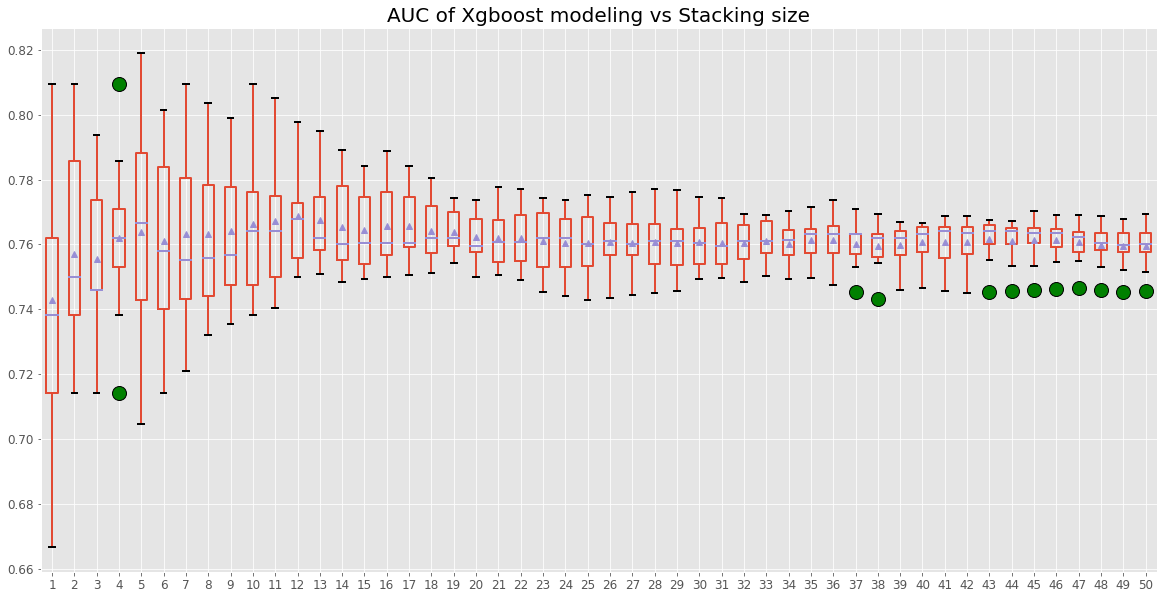

In [17]:
fig = ez_plot(zz, fontsize=12, kind='box', showmeans=True, 
              title_prop={'label': 'AUC of Xgboost modeling vs Stacking size', 'size': 20},
              boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
              whiskerprops={'linewidth': 2}, capprops={'linewidth': 2},
              medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
              flierprops=dict(marker='o', markerfacecolor='green', markersize=14, linestyle='none'))

display(fig)

In [18]:
fig.savefig('static/xgboost_auc_stacking.jpg')